In [ ]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import matplotlib.dates as mdates
from scipy.stats import poisson
from scipy.stats import geom
from scipy.stats import binom
import csv

In [ ]:
!cp -r /content/drive/MyDrive/ProbStat_HW/2.csv /content

# 1. Data pre-processing

Copy the states data from google Drive

In [161]:
data = pd.read_csv("/content/2.csv")
print(data)

           Date  AR confirmed  AZ confirmed  AR deaths  AZ deaths
0    2020-01-22             0             0          0          0
1    2020-01-23             0             0          0          0
2    2020-01-24             0             0          0          0
3    2020-01-25             0             0          0          0
4    2020-01-26             0             1          0          0
..          ...           ...           ...        ...        ...
433  2021-03-30        330188        841192       5661      16942
434  2021-03-31        330401        841884       5669      16968
435  2021-04-01        330611        842273       5678      16979
436  2021-04-02        330756        843174       5679      16998
437  2021-04-03        330972        844328       5681      17005

[438 rows x 5 columns]


In [162]:
if( not data.isnull().values.any()):
    print("Dataset has no NA values")
else:
    print(data)
    data.dropna(inplace=True)
    print(data)

Dataset has no NA values


In [163]:
data["cases_ar"] = data["AR confirmed"].diff()
data["cases_az"] = data["AZ confirmed"].diff()
data["deaths_ar"] = data["AR deaths"].diff()
data["deaths_az"] = data["AZ deaths"].diff()
print(data)

           Date  AR confirmed  AZ confirmed  ...  cases_az  deaths_ar  deaths_az
0    2020-01-22             0             0  ...       NaN        NaN        NaN
1    2020-01-23             0             0  ...       0.0        0.0        0.0
2    2020-01-24             0             0  ...       0.0        0.0        0.0
3    2020-01-25             0             0  ...       0.0        0.0        0.0
4    2020-01-26             0             1  ...       1.0        0.0        0.0
..          ...           ...           ...  ...       ...        ...        ...
433  2021-03-30        330188        841192  ...     578.0       12.0       21.0
434  2021-03-31        330401        841884  ...     692.0        8.0       26.0
435  2021-04-01        330611        842273  ...     389.0        9.0       11.0
436  2021-04-02        330756        843174  ...     901.0        1.0       19.0
437  2021-04-03        330972        844328  ...    1154.0        2.0        7.0

[438 rows x 9 columns]


setting all values at 0th index to 0 as they're NaN otherwise.


In [164]:
data.loc[0, 'cases_ar'] = 0
data.loc[0, 'cases_az'] = 0
data.loc[0, 'deaths_ar'] = 0
data.loc[0, 'deaths_az'] = 0

In [165]:
print(data)

           Date  AR confirmed  AZ confirmed  ...  cases_az  deaths_ar  deaths_az
0    2020-01-22             0             0  ...       0.0        0.0        0.0
1    2020-01-23             0             0  ...       0.0        0.0        0.0
2    2020-01-24             0             0  ...       0.0        0.0        0.0
3    2020-01-25             0             0  ...       0.0        0.0        0.0
4    2020-01-26             0             1  ...       1.0        0.0        0.0
..          ...           ...           ...  ...       ...        ...        ...
433  2021-03-30        330188        841192  ...     578.0       12.0       21.0
434  2021-03-31        330401        841884  ...     692.0        8.0       26.0
435  2021-04-01        330611        842273  ...     389.0        9.0       11.0
436  2021-04-02        330756        843174  ...     901.0        1.0       19.0
437  2021-04-03        330972        844328  ...    1154.0        2.0        7.0

[438 rows x 9 columns]


In [166]:
def remove_outliers(data, parameters):
    preprocessed = pd.DataFrame()
    for parameter in parameters:

        q1 = data[parameter].quantile(0.25)
        q2 = data[parameter].quantile(0.50)
        q3 = data[parameter].quantile(0.75)
        q4 = data[parameter].quantile(1.00)

        print("----",parameter,"----")
        print("q1 is", q1)
        print("q2 is", q2)
        print("q3 is", q3)
        print("q4 is", q4)

        iqr = q3 - q1

        print("IQR is", iqr)

        tukeys_upper = q3 + (iqr*1.5)
        tukeys_lower = q1 - (iqr*1.5)

        print("Tukey's Upper : ", tukeys_upper)
        print("Tukey's Lower : ", tukeys_lower)

        colData = data[["Date",parameter]]

        outliers = colData.loc[ ((colData[parameter] < tukeys_lower) | (colData[parameter] > tukeys_upper) & colData[parameter] != 0 ), ['Date',parameter] ]
        outliers.to_csv("outliers_"+parameter+".csv")
        print("number of outliers", outliers.shape[0])

        #filtering out values that are 0 or are >= tukeys lower and <= tukeys upper
        preprocessed = colData.loc[ (colData[parameter] == 0) | ((colData[parameter] >= tukeys_lower) & (colData[parameter] <= tukeys_upper)), ['Date',parameter] ]

        #replacing negative values with zeroes:
        preprocessed.loc[preprocessed[parameter]<0, parameter] = 0
        sns.boxplot(y=data[parameter])
        plt.show()
        print("Preprocessed", parameter ,"is")
        print(preprocessed)
        preprocessed.to_csv("processed_"+parameter+".csv")

In [167]:
def plot_data(data, parameters):
    for parameter in parameters:
        y=[datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in data["Date"]]
        x=data[parameter]
        plt.ylabel(parameter)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=50))
        plt.plot(y,x)
        plt.gcf().autofmt_xdate()
        plt.show()

---- cases_ar ----
q1 is 92.5
q2 is 534.0
q3 is 1016.5
q4 is 4304.0
IQR is 924.0
Tukey's Upper :  2402.5
Tukey's Lower :  -1293.5
number of outliers 30


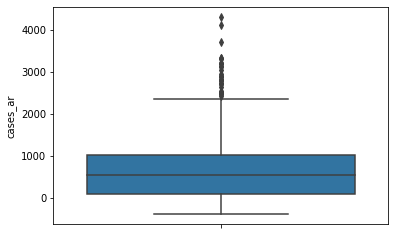

Preprocessed cases_ar is
           Date  cases_ar
0    2020-01-22       0.0
1    2020-01-23       0.0
2    2020-01-24       0.0
3    2020-01-25       0.0
4    2020-01-26       0.0
..          ...       ...
433  2021-03-30     175.0
434  2021-03-31     213.0
435  2021-04-01     210.0
436  2021-04-02     145.0
437  2021-04-03     216.0

[408 rows x 2 columns]
---- cases_az ----
q1 is 208.0
q2 is 795.0
q3 is 2554.25
q4 is 50826.0
IQR is 2346.25
Tukey's Upper :  6073.625
Tukey's Lower :  -3311.375
number of outliers 29


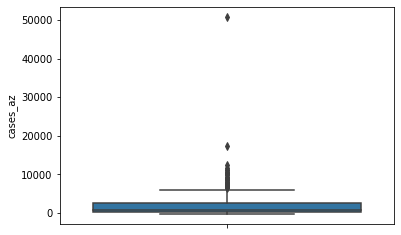

Preprocessed cases_az is
           Date  cases_az
0    2020-01-22       0.0
1    2020-01-23       0.0
2    2020-01-24       0.0
3    2020-01-25       0.0
4    2020-01-26       1.0
..          ...       ...
433  2021-03-30     578.0
434  2021-03-31     692.0
435  2021-04-01     389.0
436  2021-04-02     901.0
437  2021-04-03    1154.0

[409 rows x 2 columns]
---- deaths_ar ----
q1 is 1.0
q2 is 8.0
q3 is 18.75
q4 is 147.0
IQR is 17.75
Tukey's Upper :  45.375
Tukey's Lower :  -25.625
number of outliers 18


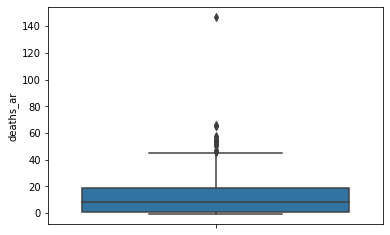

Preprocessed deaths_ar is
           Date  deaths_ar
0    2020-01-22        0.0
1    2020-01-23        0.0
2    2020-01-24        0.0
3    2020-01-25        0.0
4    2020-01-26        0.0
..          ...        ...
433  2021-03-30       12.0
434  2021-03-31        8.0
435  2021-04-01        9.0
436  2021-04-02        1.0
437  2021-04-03        2.0

[420 rows x 2 columns]
---- deaths_az ----
q1 is 1.0
q2 is 16.0
q3 is 44.75
q4 is 498.0
IQR is 43.75
Tukey's Upper :  110.375
Tukey's Lower :  -64.625
number of outliers 44


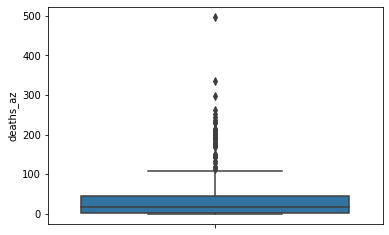

Preprocessed deaths_az is
           Date  deaths_az
0    2020-01-22        0.0
1    2020-01-23        0.0
2    2020-01-24        0.0
3    2020-01-25        0.0
4    2020-01-26        0.0
..          ...        ...
433  2021-03-30       21.0
434  2021-03-31       26.0
435  2021-04-01       11.0
436  2021-04-02       19.0
437  2021-04-03        7.0

[394 rows x 2 columns]


In [168]:
cols = ["cases_ar","cases_az", "deaths_ar", "deaths_az" ]
remove_outliers(data, cols)

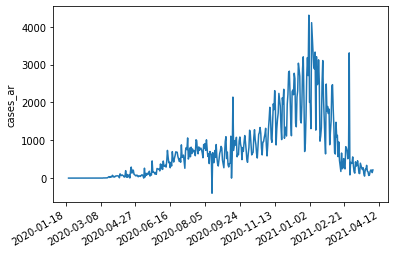

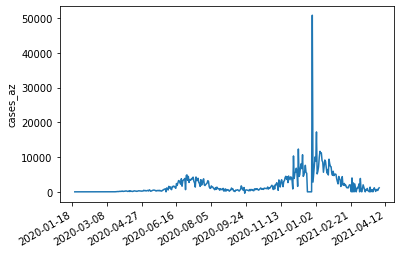

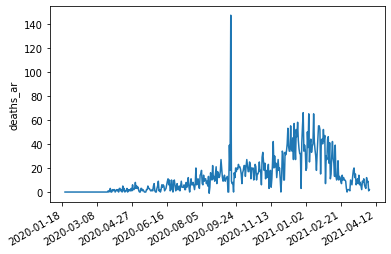

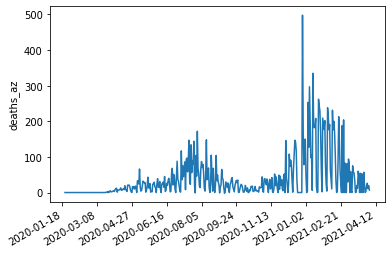

In [169]:
plot_data(data, cols)

# Question 2

## Inference 1

-> Helper Functions:

In [170]:
def linear_regression(x, y):
    xt = np.transpose(x)
    xt_x = np.matmul(xt, x)
    xt_x_inverse = np.linalg.pinv(xt_x)
    xt_x_inverse_xt = np.matmul(xt_x_inverse, xt)
    b = np.matmul(xt_x_inverse_xt, y)
    return b


def calculate_MAPE(y1, y2):
    y1_modified = np.array([])
    y2_modified = np.array([])
    for i in range(len(y1)):
        if y1[i] != 0:
            y1_modified = np.append(y1_modified, y1[i])
            y2_modified = np.append(y2_modified, y2[i])
    return np.sum((np.abs(y1_modified - y2_modified)) / y1_modified) * (100 / len(y1_modified))


def calculate_MSE(y1, y2):
    return np.sum((y1 - y2) * (y1 - y2)) / len(y1)

def prepare_table(x, t):
    x = np.atleast_2d(x)
    for i in range(t):
        x = np.insert(x, i + 1, 0, axis=1)
        x[i + 1:, i + 1] = x[:-(i + 1), 0]
    return x[t:]

In [171]:
df = pd.read_csv('processed_cases_ar.csv')
data = df.to_numpy()
data = data[192:220, :]

In [172]:
data

array([[192, '2020-08-01', 662.0],
       [193, '2020-08-02', 537.0],
       [194, '2020-08-03', 887.0],
       [195, '2020-08-04', 784.0],
       [196, '2020-08-05', 912.0],
       [197, '2020-08-06', 735.0],
       [198, '2020-08-07', 1011.0],
       [199, '2020-08-08', 772.0],
       [200, '2020-08-09', 572.0],
       [201, '2020-08-10', 645.0],
       [202, '2020-08-11', 383.0],
       [203, '2020-08-12', 703.0],
       [204, '2020-08-13', 652.0],
       [205, '2020-08-14', 626.0],
       [206, '2020-08-15', 0.0],
       [207, '2020-08-16', 673.0],
       [208, '2020-08-17', 412.0],
       [209, '2020-08-18', 410.0],
       [210, '2020-08-19', 729.0],
       [211, '2020-08-20', 549.0],
       [212, '2020-08-21', 887.0],
       [213, '2020-08-22', 547.0],
       [214, '2020-08-23', 375.0],
       [215, '2020-08-24', 320.0],
       [216, '2020-08-25', 480.0],
       [217, '2020-08-26', 649.0],
       [218, '2020-08-27', 722.0],
       [219, '2020-08-28', 838.0]], dtype=object)

### AR_Cases: AR3 and EWMA with alpha = 0.5 


---


In [173]:
data = data[:, 2:].astype(np.float64)
x = prepare_table(data, 3)
y = data[3:]
x = np.insert(x, x.shape[1], 1, axis=1)
y_actual = np.array([])
y_predicted = np.array([])
y_predicted_ewma = np.array([])

for j in range(7):
    x1 = x[:-(7 - j)]
    y1 = y[:-(7 - j)]

    # Auto Regression
    b = linear_regression(x1, y1)
    y_actual = np.append(y_actual, y[-(7 - j)])
    y_predicted = np.append(y_predicted, np.matmul(np.transpose(x[-(7 - j)]), b))

    # EWMA
    predicted_y = 0
    multiplier = 0.5
    for k in range(len(x1)):
        predicted_y += multiplier * x1[-(1 + k)][0]
        multiplier *= (1 - multiplier)
    y_predicted_ewma = np.append(y_predicted_ewma, predicted_y)

MAPE_error_ar = calculate_MAPE(y_actual, y_predicted)
MSE_error_ar = calculate_MSE(y_actual, y_predicted)
print(MAPE_error_ar)
print(MSE_error_ar)
MAPE_error_ewma = calculate_MAPE(y_actual, y_predicted_ewma)
MSE_error_ewma = calculate_MSE(y_actual, y_predicted_ewma)
print(MAPE_error_ewma)
print(MSE_error_ewma)

2.115513584788008e-13
2.361526793427059e-24
154.18028468246587
565521.4493848376


### AR_Cases: AR5 and EWMA with alpha = 0.8 

---



In [174]:
x = prepare_table(data, 5)
y = data[5:]
x = np.insert(x, x.shape[1], 1, axis=1)
y_actual = np.array([])
y_predicted = np.array([])
y_predicted_ewma = np.array([])

for j in range(7):
    x1 = x[:-(7 - j)]
    y1 = y[:-(7 - j)]

    # Auto Regression
    b = linear_regression(x1, y1)
    y_actual = np.append(y_actual, y[-(7 - j)])
    y_predicted = np.append(y_predicted, np.matmul(np.transpose(x[-(7 - j)]), b))

    # EWMA
    predicted_y = 0
    multiplier = 0.8
    for k in range(len(x1)):
        predicted_y += multiplier * x1[-(1 + k)][0]
        multiplier *= (1 - multiplier)
    y_predicted_ewma = np.append(y_predicted_ewma, predicted_y)

MAPE_error_ar = calculate_MAPE(y_actual, y_predicted)
MSE_error_ar = calculate_MSE(y_actual, y_predicted)
print(MAPE_error_ar)
print(MSE_error_ar)
MAPE_error_ewma = calculate_MAPE(y_actual, y_predicted_ewma)
MSE_error_ewma = calculate_MSE(y_actual, y_predicted_ewma)
print(MAPE_error_ewma)
print(MSE_error_ewma)

2.2272001690896053e-13
2.446922113361384e-24
136.06646430852174
454720.72314023116


In [175]:
df = pd.read_csv('processed_cases_az.csv')
data = df.to_numpy()
data = data[192:220, :]

In [176]:
data

array([[192, '2020-08-01', 2992.0],
       [193, '2020-08-02', 1465.0],
       [194, '2020-08-03', 1030.0],
       [195, '2020-08-04', 1008.0],
       [196, '2020-08-05', 1698.0],
       [197, '2020-08-06', 1444.0],
       [198, '2020-08-07', 1406.0],
       [199, '2020-08-08', 1054.0],
       [200, '2020-08-09', 816.0],
       [201, '2020-08-10', 600.0],
       [202, '2020-08-11', 1214.0],
       [203, '2020-08-12', 706.0],
       [204, '2020-08-13', 1351.0],
       [205, '2020-08-14', 927.0],
       [206, '2020-08-15', 933.0],
       [207, '2020-08-16', 883.0],
       [208, '2020-08-17', 468.0],
       [209, '2020-08-18', 915.0],
       [210, '2020-08-19', 637.0],
       [211, '2020-08-20', 723.0],
       [212, '2020-08-21', 619.0],
       [213, '2020-08-22', 996.0],
       [214, '2020-08-23', 208.0],
       [215, '2020-08-24', 310.0],
       [216, '2020-08-25', 860.0],
       [217, '2020-08-26', 186.0],
       [218, '2020-08-27', 680.0],
       [219, '2020-08-28', 519.0]], dtype=obj

### AZ_Cases: AR3 and EWMA with alpha = 0.5

---



In [177]:
data = data[:, 2:].astype(np.float64)
x = prepare_table(data, 3)
y = data[3:]
x = np.insert(x, x.shape[1], 1, axis=1)
y_actual = np.array([])
y_predicted = np.array([])
y_predicted_ewma = np.array([])

for j in range(7):
    x1 = x[:-(7 - j)]
    y1 = y[:-(7 - j)]

    # Auto Regression
    b = linear_regression(x1, y1)
    y_actual = np.append(y_actual, y[-(7 - j)])
    y_predicted = np.append(y_predicted, np.matmul(np.transpose(x[-(7 - j)]), b))

    # EWMA
    predicted_y = 0
    multiplier = 0.5
    for k in range(len(x1)):
        predicted_y += multiplier * x1[-(1 + k)][0]
        multiplier *= (1 - multiplier)
    y_predicted_ewma = np.append(y_predicted_ewma, predicted_y)

MAPE_error_ar = calculate_MAPE(y_actual, y_predicted)
MSE_error_ar = calculate_MSE(y_actual, y_predicted)
print(MAPE_error_ar)
print(MSE_error_ar)
MAPE_error_ewma = calculate_MAPE(y_actual, y_predicted_ewma)
MSE_error_ewma = calculate_MSE(y_actual, y_predicted_ewma)
print(MAPE_error_ewma)
print(MSE_error_ewma)

2.6336862378883687e-13
1.6415519271159066e-24
372.5972205567083
1472736.3560948467


### AZ_Cases: AR5 and EWMA with alpha = 0.8 

---


In [178]:
x = prepare_table(data, 5)
y = data[5:]
x = np.insert(x, x.shape[1], 1, axis=1)
y_actual = np.array([])
y_predicted = np.array([])
y_predicted_ewma = np.array([])

for j in range(7):
    x1 = x[:-(7 - j)]
    y1 = y[:-(7 - j)]

    # Auto Regression
    b = linear_regression(x1, y1)
    y_actual = np.append(y_actual, y[-(7 - j)])
    y_predicted = np.append(y_predicted, np.matmul(np.transpose(x[-(7 - j)]), b))

    # EWMA
    predicted_y = 0
    multiplier = 0.8
    for k in range(len(x1)):
        predicted_y += multiplier * x1[-(1 + k)][0]
        multiplier *= (1 - multiplier)
    y_predicted_ewma = np.append(y_predicted_ewma, predicted_y)

MAPE_error_ar = calculate_MAPE(y_actual, y_predicted)
MSE_error_ar = calculate_MSE(y_actual, y_predicted)
print(MAPE_error_ar)
print(MSE_error_ar)
MAPE_error_ewma = calculate_MAPE(y_actual, y_predicted_ewma)
MSE_error_ewma = calculate_MSE(y_actual, y_predicted_ewma)
print(MAPE_error_ewma)
print(MSE_error_ewma)

1.1438829752269654e-12
1.5568836213918334e-23
336.03397414319295
1164369.2151349573


In [179]:
df = pd.read_csv('processed_deaths_ar.csv')
data = df.to_numpy()
data = data[192:220, :]

In [180]:
data

array([[192, '2020-08-01', 5.0],
       [193, '2020-08-02', 3.0],
       [194, '2020-08-03', 14.0],
       [195, '2020-08-04', 15.0],
       [196, '2020-08-05', 18.0],
       [197, '2020-08-06', 7.0],
       [198, '2020-08-07', 6.0],
       [199, '2020-08-08', 14.0],
       [200, '2020-08-09', 9.0],
       [201, '2020-08-10', 11.0],
       [202, '2020-08-11', 11.0],
       [203, '2020-08-12', 7.0],
       [204, '2020-08-13', 9.0],
       [205, '2020-08-14', 5.0],
       [206, '2020-08-15', 13.0],
       [207, '2020-08-16', 0.0],
       [208, '2020-08-17', 4.0],
       [209, '2020-08-18', 16.0],
       [210, '2020-08-19', 12.0],
       [211, '2020-08-20', 10.0],
       [212, '2020-08-21', 22.0],
       [213, '2020-08-22', 11.0],
       [214, '2020-08-23', 13.0],
       [215, '2020-08-24', 9.0],
       [216, '2020-08-25', 15.0],
       [217, '2020-08-26', 21.0],
       [218, '2020-08-27', 7.0],
       [219, '2020-08-28', 17.0]], dtype=object)

### AR_Deaths: AR3 and EWMA with alpha = 0.5 

---

In [181]:
data = data[:, 2:].astype(np.float64)
x = prepare_table(data, 3)
y = data[3:]
x = np.insert(x, x.shape[1], 1, axis=1)
y_actual = np.array([])
y_predicted = np.array([])
y_predicted_ewma = np.array([])

for j in range(7):
    x1 = x[:-(7 - j)]
    y1 = y[:-(7 - j)]

    # Auto Regression
    b = linear_regression(x1, y1)
    y_actual = np.append(y_actual, y[-(7 - j)])
    y_predicted = np.append(y_predicted, np.matmul(np.transpose(x[-(7 - j)]), b))

    # EWMA
    predicted_y = 0
    multiplier = 0.5
    for k in range(len(x1)):
        predicted_y += multiplier * x1[-(1 + k)][0]
        multiplier *= (1 - multiplier)
    y_predicted_ewma = np.append(y_predicted_ewma, predicted_y)

MAPE_error_ar = calculate_MAPE(y_actual, y_predicted)
MSE_error_ar = calculate_MSE(y_actual, y_predicted)
print(MAPE_error_ar)
print(MSE_error_ar)
MAPE_error_ewma = calculate_MAPE(y_actual, y_predicted_ewma)
MSE_error_ewma = calculate_MSE(y_actual, y_predicted_ewma)
print(MAPE_error_ewma)
print(MSE_error_ewma)

1.402677370210973e-13
5.212116695210256e-28
131.0793234496849
212.04056998621758


### AR_Deaths: AR5 and EWMA with alpha = 0.8 

---


In [182]:
x = prepare_table(data, 5)
y = data[5:]
x = np.insert(x, x.shape[1], 1, axis=1)
y_actual = np.array([])
y_predicted = np.array([])
y_predicted_ewma = np.array([])

for j in range(7):
    x1 = x[:-(7 - j)]
    y1 = y[:-(7 - j)]

    # Auto Regression
    b = linear_regression(x1, y1)
    y_actual = np.append(y_actual, y[-(7 - j)])
    y_predicted = np.append(y_predicted, np.matmul(np.transpose(x[-(7 - j)]), b))

    # EWMA
    predicted_y = 0
    multiplier = 0.8
    for k in range(len(x1)):
        predicted_y += multiplier * x1[-(1 + k)][0]
        multiplier *= (1 - multiplier)
    y_predicted_ewma = np.append(y_predicted_ewma, predicted_y)

MAPE_error_ar = calculate_MAPE(y_actual, y_predicted)
MSE_error_ar = calculate_MSE(y_actual, y_predicted)
print(MAPE_error_ar)
print(MSE_error_ar)
MAPE_error_ewma = calculate_MAPE(y_actual, y_predicted_ewma)
MSE_error_ewma = calculate_MSE(y_actual, y_predicted_ewma)
print(MAPE_error_ewma)
print(MSE_error_ewma)

4.0310517462845836e-13
2.2350683333211895e-27
125.42159183050956
201.16734370022036


In [183]:
df = pd.read_csv('processed_deaths_az.csv')
data = df.to_numpy()
data = data[187:214, :]

In [184]:
data

array([[192, '2020-08-01', 53.0],
       [193, '2020-08-02', 18.0],
       [194, '2020-08-03', 14.0],
       [195, '2020-08-04', 66.0],
       [196, '2020-08-05', 87.0],
       [197, '2020-08-06', 70.0],
       [198, '2020-08-07', 79.0],
       [199, '2020-08-08', 56.0],
       [200, '2020-08-09', 13.0],
       [201, '2020-08-10', 4.0],
       [202, '2020-08-11', 45.0],
       [204, '2020-08-13', 36.0],
       [205, '2020-08-14', 40.0],
       [206, '2020-08-15', 69.0],
       [207, '2020-08-16', 14.0],
       [208, '2020-08-17', 0.0],
       [209, '2020-08-18', 23.0],
       [210, '2020-08-19', 105.0],
       [211, '2020-08-20', 50.0],
       [212, '2020-08-21', 4.0],
       [213, '2020-08-22', 68.0],
       [214, '2020-08-23', 15.0],
       [215, '2020-08-24', 0.0],
       [216, '2020-08-25', 21.0],
       [217, '2020-08-26', 104.0],
       [218, '2020-08-27', 33.0],
       [219, '2020-08-28', 49.0]], dtype=object)

### AZ_Deaths: AR3 and EWMA with alpha = 0.5 

---


In [185]:
data = data[:, 2:].astype(np.float64)
x = prepare_table(data, 3)
y = data[3:]
x = np.insert(x, x.shape[1], 1, axis=1)
y_actual = np.array([])
y_predicted = np.array([])
y_predicted_ewma = np.array([])

for j in range(7):
    x1 = x[:-(7 - j)]
    y1 = y[:-(7 - j)]

    # Auto Regression
    b = linear_regression(x1, y1)
    y_actual = np.append(y_actual, y[-(7 - j)])
    y_predicted = np.append(y_predicted, np.matmul(np.transpose(x[-(7 - j)]), b))

    # EWMA
    predicted_y = 0
    multiplier = 0.5
    for k in range(len(x1)):
        predicted_y += multiplier * x1[-(1 + k)][0]
        multiplier *= (1 - multiplier)
    y_predicted_ewma = np.append(y_predicted_ewma, predicted_y)

MAPE_error_ar = calculate_MAPE(y_actual, y_predicted)
MSE_error_ar = calculate_MSE(y_actual, y_predicted)
print(MAPE_error_ar)
print(MSE_error_ar)
MAPE_error_ewma = calculate_MAPE(y_actual, y_predicted_ewma)
MSE_error_ewma = calculate_MSE(y_actual, y_predicted_ewma)
print(MAPE_error_ewma)
print(MSE_error_ewma)

1.0977711653367589e-13
6.623533051776912e-27
196.14259432433573
3734.8918130018837


### AZ_Deaths: AR5 and EWMA with alpha = 0.8 

---


In [186]:
x = prepare_table(data, 5)
y = data[5:]
x = np.insert(x, x.shape[1], 1, axis=1)
y_actual = np.array([])
y_predicted = np.array([])
y_predicted_ewma = np.array([])

for j in range(7):
    x1 = x[:-(7 - j)]
    y1 = y[:-(7 - j)]

    # Auto Regression
    b = linear_regression(x1, y1)
    y_actual = np.append(y_actual, y[-(7 - j)])
    y_predicted = np.append(y_predicted, np.matmul(np.transpose(x[-(7 - j)]), b))

    # EWMA
    predicted_y = 0
    multiplier = 0.8
    for k in range(len(x1)):
        predicted_y += multiplier * x1[-(1 + k)][0]
        multiplier *= (1 - multiplier)
    y_predicted_ewma = np.append(y_predicted_ewma, predicted_y)

MAPE_error_ar = calculate_MAPE(y_actual, y_predicted)
MSE_error_ar = calculate_MSE(y_actual, y_predicted)
print(MAPE_error_ar)
print(MSE_error_ar)
MAPE_error_ewma = calculate_MAPE(y_actual, y_predicted_ewma)
MSE_error_ewma = calculate_MSE(y_actual, y_predicted_ewma)
print(MAPE_error_ewma)
print(MSE_error_ewma)

3.7259387553546353e-13
2.615057635300212e-26
191.2781143225296
3611.812829857423


## Inference 2

Extracting feb 2021 and march 2021 data for both the states AR and AZ

In [187]:
dataar = pd.read_csv('processed_cases_ar.csv')
ar_feb_cases = (dataar.loc[(pd.to_datetime(dataar["Date"], format="%Y-%m-%d") >= datetime.datetime(2021, 2, 1) ) & (pd.to_datetime(dataar["Date"], format="%Y-%m-%d") <= datetime.datetime(2021, 2, 28 )) ])
ar_march_cases = (dataar.loc[ (pd.to_datetime(dataar["Date"], format="%Y-%m-%d") >= datetime.datetime(2021, 3, 1) ) & (pd.to_datetime(dataar["Date"], format="%Y-%m-%d") <= datetime.datetime(2021, 3, 31)) ])

dataaz = pd.read_csv('processed_cases_az.csv')
az_feb_cases = (dataaz.loc[(pd.to_datetime(dataaz["Date"], format="%Y-%m-%d") >= datetime.datetime(2021, 2, 1) ) & (pd.to_datetime(dataaz["Date"], format="%Y-%m-%d") <= datetime.datetime(2021, 2, 28 )) ])
az_march_cases = (dataaz.loc[ (pd.to_datetime(dataaz["Date"], format="%Y-%m-%d") >= datetime.datetime(2021, 3, 1) ) & (pd.to_datetime(dataaz["Date"], format="%Y-%m-%d") <= datetime.datetime(2021, 3, 31)) ])

datar = pd.read_csv('processed_deaths_ar.csv')
ar_feb_d = (datar.loc[(pd.to_datetime(datar["Date"], format="%Y-%m-%d") >= datetime.datetime(2021, 2, 1) ) & (pd.to_datetime(datar["Date"], format="%Y-%m-%d") <= datetime.datetime(2021, 2, 28 )) ])
ar_march_d = (datar.loc[ (pd.to_datetime(datar["Date"], format="%Y-%m-%d") >= datetime.datetime(2021, 3, 1) ) & (pd.to_datetime(datar["Date"], format="%Y-%m-%d") <= datetime.datetime(2021, 3, 31))])

dataz = pd.read_csv('processed_deaths_az.csv')
az_feb_d = (dataz.loc[(pd.to_datetime(dataz["Date"], format="%Y-%m-%d") >= datetime.datetime(2021, 2, 1) ) & (pd.to_datetime(dataz["Date"], format="%Y-%m-%d") <= datetime.datetime(2021, 2, 28 )) ])
az_march_d = (dataz.loc[ (pd.to_datetime(dataz["Date"], format="%Y-%m-%d") >= datetime.datetime(2021, 3, 1) ) & (pd.to_datetime(dataz["Date"], format="%Y-%m-%d") <= datetime.datetime(2021, 3, 31))])

In [188]:
print(dataar)
print(ar_feb_cases)
print(ar_march_cases)
print(dataaz)
print(datar)
print(dataz)

     Unnamed: 0        Date  cases_ar
0             0  2020-01-22       0.0
1             1  2020-01-23       0.0
2             2  2020-01-24       0.0
3             3  2020-01-25       0.0
4             4  2020-01-26       0.0
..          ...         ...       ...
403         433  2021-03-30     175.0
404         434  2021-03-31     213.0
405         435  2021-04-01     210.0
406         436  2021-04-02     145.0
407         437  2021-04-03     216.0

[408 rows x 3 columns]
     Unnamed: 0        Date  cases_ar
349         376  2021-02-01    1226.0
350         377  2021-02-02    1510.0
351         380  2021-02-05    1824.0
352         381  2021-02-06    1341.0
353         382  2021-02-07     674.0
354         383  2021-02-08     636.0
355         384  2021-02-09    1475.0
356         385  2021-02-10    1093.0
357         386  2021-02-11    1130.0
358         387  2021-02-12     567.0
359         388  2021-02-13     955.0
360         389  2021-02-14     467.0
361         390  2021-02-1

###  Walds one sample test for cases for the state AR

In [189]:
print("Null hypothesis (H0):")
print("the mean of daily cases for March’21 is equal to the mean of daily cases for Feb’21 for state AR")
print("Alternate hypothesis(H1):")
print("the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AR")
mcfAR = ar_feb_cases["cases_ar"].mean()

mcmAR = ar_march_cases["cases_ar"].mean()
# print(mcmAR)

num = mcmAR - mcfAR
den = (mcmAR/len(ar_march_cases["cases_ar"]))
den = math.sqrt(den)

print("walds 1 sample testing statistic is |w|=",abs(num/den)," which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis")

Null hypothesis (H0):
the mean of daily cases for March’21 is equal to the mean of daily cases for Feb’21 for state AR
Alternate hypothesis(H1):
the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AR
walds 1 sample testing statistic is |w|= 176.97136033181553  which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily cases for March’21 is equal to the mean of daily cases for Feb’21 for state AR

**Alternate hypothesis(H1):**

the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AR

walds 1 sample testing statistic is |w|= 176.97136033181553  which is greater than z_alpha/2 = 1.96 

**so reject the NULL hypothesis**

### Walds one sample test for cases for the state AZ

In [190]:
print("Null hypothesis (H0):")
print("the mean of daily cases for March’21 is equal to the mean of daily cases for Feb’21 for state AZ")
print("Alternate hypothesis(H1):")
print("the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AZ")
mcfAZ = az_feb_cases["cases_az"].mean()

mcmAZ = az_march_cases["cases_az"].mean()
# print(mcmAR)

num = mcmAZ - mcfAZ
den = (mcmAR/len(az_march_cases["cases_az"]))
den = math.sqrt(den)

print("walds 1 sample testing statistic is |w|=",abs(num/den)," which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis")

Null hypothesis (H0):
the mean of daily cases for March’21 is equal to the mean of daily cases for Feb’21 for state AZ
Alternate hypothesis(H1):
the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AZ
walds 1 sample testing statistic is |w|= 469.68524098962575  which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily cases for March’21 is equal to the mean of daily cases for Feb’21 for state AZ

**Alternate hypothesis(H1):**

the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AZ

walds 1 sample testing statistic is |w|= 469.68524098962575  which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis


### Walds one sample test for deaths for the state AR

In [191]:
print("Null hypothesis (H0):")
print("the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AR")
print("Alternate hypothesis(H1):")
print("the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AR")
mdfAR = ar_feb_d['deaths_ar'].mean()
# print(mcfAR)

mdmAR = ar_march_d['deaths_ar'].mean()
# print(mcmAR)

num = mdmAR - mdfAR
den = mdmAR/len(ar_march_d['deaths_ar'])
den = math.sqrt(den)

print("walds 1 sample testing statistic is |w|=",abs(num/den)," which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis")

Null hypothesis (H0):
the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AR
Alternate hypothesis(H1):
the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AR
walds 1 sample testing statistic is |w|= 22.676078418998358  which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AR

**Alternate hypothesis(H1):**

the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AR

walds 1 sample testing statistic is |w|= 22.676078418998358  which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis


### Walds one sample test for deaths for the state AZ

In [192]:
print("Null hypothesis (H0):")
print("the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AZ")
print("Alternate hypothesis(H1):")
print("the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AZ")
mdfAR = az_feb_d['deaths_az'].mean()
# print(mcfAR)

mdmAR = az_march_d['deaths_az'].mean()
# print(mcmAR)

num = mdmAR - mdfAR
den = mdmAR/len(az_march_d['deaths_az'])
den = math.sqrt(den)

print("walds 1 sample testing statistic is |w|=",abs(num/den)," which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis")

Null hypothesis (H0):
the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AZ
Alternate hypothesis(H1):
the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AZ
walds 1 sample testing statistic is |w|= 5.132697088004606  which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AZ

**Alternate hypothesis(H1):**

the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AZ

walds 1 sample testing statistic is |w|= 5.132697088004606  which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis


### Z test for cases for the state AR

In [193]:
print("Null hypothesis (H0):")
print("the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AR")
print("Alternate hypothesis(H1):")
print("the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AR")
mcfAR = ar_feb_cases["cases_ar"].mean()

mcmAR = ar_march_cases["cases_ar"].mean()
# print(mcmAR)

num = mcmAR - mcfAR
div = (1/(len(dataar["cases_ar"]) - 1) )
sum = 0
for i in range(len(dataar)):
    sum = sum + math.pow((dataar["cases_ar"].mean() - dataar["cases_ar"][i]),2)
sum = sum /div
sigma =math.sqrt(sum)
den = sigma * (1/math.sqrt(len(ar_march_cases)))

print("z test statistic is |z|=",abs(num/den)," which is less than z_alpha/2 = 1.96 so fail to reject the NULL hypothesis")

Null hypothesis (H0):
the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AR
Alternate hypothesis(H1):
the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AR
z test statistic is |z|= 0.011774503724912604  which is less than z_alpha/2 = 1.96 so fail to reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AR

**Alternate hypothesis(H1):**

the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AR

z test statistic is |z|= 0.011774503724912604  which is less than z_alpha/2 = 1.96 so fail to reject the NULL hypothesis


### Z test for cases for the state AZ

In [194]:
print("Null hypothesis (H0):")
print("the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AZ")
print("Alternate hypothesis(H1):")
print("the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AZ")
mcfAR = az_feb_cases["cases_az"].mean()

mcmAR = az_march_cases["cases_az"].mean()
# print(mcmAR)

num = mcmAR - mcfAR
div = (1/(len(dataaz["cases_az"]) - 1) )
sum = 0
for i in range(len(dataaz)):
    sum = sum + math.pow((dataaz["cases_az"].mean() - dataaz["cases_az"][i]),2)
sum = sum /div
sigma =math.sqrt(sum)
den = sigma * (1/math.sqrt(len(az_march_cases)))

print("z test statistic is |z|=",abs(num/den)," which is less than z_alpha/2 = 1.96 so fail to reject the NULL hypothesis")

Null hypothesis (H0):
the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AZ
Alternate hypothesis(H1):
the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AZ
z test statistic is |z|= 0.011955757502414467  which is less than z_alpha/2 = 1.96 so fail to reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AZ

**Alternate hypothesis(H1):**

the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AZ

z test statistic is |z|= 0.011955757502414467  which is less than z_alpha/2 = 1.96 so fail to reject the NULL hypothesis


### Z test for deaths for the state AR

In [195]:
print("Null hypothesis (H0):")
print("the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AR")
print("Alternate hypothesis(H1):")
print("the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AR")
mcfAR = ar_feb_d['deaths_ar'].mean()

mcmAR = ar_march_d['deaths_ar'].mean()
# print(mcmAR)

num = mcmAR - mcfAR
div = (1/(len(datar["deaths_ar"]) - 1) )
sum = 0
for i in range(len(datar)):
    sum = sum + math.pow((datar["deaths_ar"].mean() - datar["deaths_ar"][i]),2)
sum = sum /div
sigma =math.sqrt(sum)
den = sigma * (1/math.sqrt(len(ar_march_d['deaths_ar'])))

print("z test statistic is |z|=",abs(num/den)," which is less than z_alpha/2 = 1.96 so fail to reject the NULL hypothesis")

Null hypothesis (H0):
the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AR
Alternate hypothesis(H1):
the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AR
z test statistic is |z|= 0.012708532191771404  which is less than z_alpha/2 = 1.96 so fail to reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AR

**Alternate hypothesis(H1):**

the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AR

z test statistic is |z|= 0.012708532191771404  which is less than z_alpha/2 = 1.96 so fail to reject the NULL hypothesis


### Z test for deaths for the state AZ

In [196]:
print("Null hypothesis (H0):")
print("the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AZ")
print("Alternate hypothesis(H1):")
print("the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AZ")
mcfAR = az_feb_d['deaths_az'].mean()

mcmAR = az_march_d['deaths_az'].mean()
# print(mcmAR)

num = mcmAR - mcfAR
div = (1/(len(dataz["deaths_az"]) - 1) )
sum = 0
for i in range(len(dataz)):
    sum = sum + math.pow((dataz["deaths_az"].mean() - dataz["deaths_az"][i]),2)
sum = sum /div
sigma =math.sqrt(sum)
den = sigma * (1/math.sqrt(len(az_march_d['deaths_az'])))

print("z test statistic is |z|=",abs(num/den)," which is less than z_alpha/2 = 1.96 so fail to reject the NULL hypothesis")

Null hypothesis (H0):
the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AZ
Alternate hypothesis(H1):
the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AZ
z test statistic is |z|= 0.002833449982254319  which is less than z_alpha/2 = 1.96 so fail to reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AZ

**Alternate hypothesis(H1):**

the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AZ

z test statistic is |z|= 0.002833449982254319  which is less than z_alpha/2 = 1.96 so fail to reject the NULL hypothesis

### One sample T test for cases for the state AR

In [197]:
print("Null hypothesis (H0):")
print("the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AR")
print("Alternate hypothesis(H1):")
print("the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AR")

mcfAR = ar_feb_cases['cases_ar'].mean()

mcmAR = ar_march_cases['cases_ar'].mean()
# print(mcmAR)

num = mcmAR - mcfAR
div = (1/(len(ar_march_cases['cases_ar']) - 1) )
sum = 0

for i in range(len(ar_march_cases)):
    # print(march2021["AR confirmed"][0])
    sum = sum + math.pow((ar_march_cases['cases_ar'].mean() - ar_march_cases['cases_ar'].iloc[i]),2)
sum = sum /div
sigma =math.sqrt(sum)
den = sigma * (1/math.sqrt(len(ar_march_cases)))
print("T statistic |T|=",abs(num/den),"which is less than t(",len(ar_march_cases)-1,",alpha/2)=2.0423 so fail to reject the NULL hypothesis")

Null hypothesis (H0):
the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AR
Alternate hypothesis(H1):
the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AR
T statistic |T|= 0.7181046741596464 which is less than t( 30 ,alpha/2)=2.0423 so fail to reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AR

**Alternate hypothesis(H1):**

the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AR

T statistic |T|= 0.7181046741596464 which is less than t( 30 ,alpha/2)=2.0423 so fail to reject the NULL hypothesis


### One sample T test for cases for the state AZ

In [198]:
print("Null hypothesis (H0):")
print("the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AZ")
print("Alternate hypothesis(H1):")
print("the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AZ")
mcfAR = az_feb_cases['cases_az'].mean()

mcmAR = az_march_cases['cases_az'].mean()
# print(mcmAR)

num = mcmAR - mcfAR
div = (1/(len(az_march_cases['cases_az']) - 1) )
sum = 0

for i in range(len(az_march_cases['cases_az'])):
    # print(march2021["AR confirmed"][0])
    sum = sum + math.pow((az_march_cases['cases_az'].mean() - az_march_cases['cases_az'].iloc[i]),2)
sum = sum /div
sigma =math.sqrt(sum)
den = sigma * (1/math.sqrt(len(az_march_cases['cases_az'])))
print("T statistic |T|=",abs(num/den),"which is less than t(",len(az_march_cases['cases_az'])-1,",alpha/2)=2.0423 so fail to reject the NULL hypothesis")

Null hypothesis (H0):
the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AZ
Alternate hypothesis(H1):
the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AZ
T statistic |T|= 0.3050772115889984 which is less than t( 30 ,alpha/2)=2.0423 so fail to reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AZ

**Alternate hypothesis(H1):**

the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AZ

T statistic |T|= 0.3050772115889984 which is less than t( 30 ,alpha/2)=2.0423 so fail to reject the NULL hypothesis


### One sample T test for deaths for the state AR

In [199]:
print("Null hypothesis (H0):")
print("the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AR")
print("Alternate hypothesis(H1):")
print("the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AR")
mcfAR = ar_feb_d['deaths_ar'].mean()

mcmAR = ar_march_d['deaths_ar'].mean()
# print(mcmAR)

num = mcmAR - mcfAR
div = (1/(len(ar_march_d['deaths_ar']) - 1) )
sum = 0

for i in range(len(ar_march_d['deaths_ar'])):
    # print(march2021["AR confirmed"][0])
    sum = sum + math.pow((ar_march_d['deaths_ar'].mean() - ar_march_d['deaths_ar'].iloc[i]),2)
sum = sum /div
sigma =math.sqrt(sum)
den = sigma * (1/math.sqrt(len(ar_march_d['deaths_ar'])))
print("T statistic |T|=",abs(num/den),"which is less than t(",len(ar_march_d['deaths_ar'])-1,",alpha/2)=2.0423 so fail to reject the NULL hypothesis")

Null hypothesis (H0):
the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AR
Alternate hypothesis(H1):
the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AR
T statistic |T|= 0.41897656409142037 which is less than t( 30 ,alpha/2)=2.0423 so fail to reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AR

**Alternate hypothesis(H1):**

the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AR

T statistic |T|= 0.41897656409142037 which is less than t( 30 ,alpha/2)=2.0423 so fail to reject the NULL hypothesis


### One sample T test for deaths for the state AZ

In [200]:
print("Null hypothesis (H0):")
print("the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AZ")
print("Alternate hypothesis(H1):")
print("the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AZ")
mcfAR = az_feb_d['deaths_az'].mean()

mcmAR = az_march_d['deaths_az'].mean()
# print(mcmAR)

num = mcmAR - mcfAR
div = (1/(len(az_march_d['deaths_az']) - 1) )
sum = 0

for i in range(len(az_march_d)):
    # print(march2021["AR confirmed"][0])
    sum = sum + math.pow((az_march_d['deaths_az'].mean() - az_march_d['deaths_az'].iloc[i]),2)
sum = sum /div
sigma =math.sqrt(sum)
den = sigma * (1/math.sqrt(len(az_march_d['deaths_az'])))
print("T statistic |T|=",abs(num/den),"which is less than t(",len(az_march_d['deaths_az'])-1,",alpha/2)=2.0423 so fail to reject the NULL hypothesis")

Null hypothesis (H0):
the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AZ
Alternate hypothesis(H1):
the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AZ
T statistic |T|= 0.032173587986571585 which is less than t( 30 ,alpha/2)=2.0423 so fail to reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AZ

**Alternate hypothesis(H1):**

the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AZ

T statistic |T|= 0.032173587986571585 which is less than t( 30 ,alpha/2)=2.0423 so fail to reject the NULL hypothesis


### Two sample walds test for cases for the state AR

In [201]:
print("Null hypothesis (H0):")
print("the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AR")
print("Alternate hypothesis(H1):")
print("the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AR")
mcfAR = ar_feb_cases['cases_ar'].mean()

mcmAR = ar_march_cases['cases_ar'].mean()
# print(mcmAR)

num = mcfAR - mcmAR
den = (mcfAR/len(ar_feb_cases)) + (mcmAR/len(ar_march_cases))
den = math.sqrt(den)

print("walds 2 sample testing statistic is |w|=",abs(num/den)," which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis")



Null hypothesis (H0):
the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AR
Alternate hypothesis(H1):
the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AR
walds 2 sample testing statistic is |w|= 81.5397058501656  which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AR

**Alternate hypothesis(H1):**

the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AR

walds 2 sample testing statistic is |w|= 81.5397058501656  which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis


### Two sample walds test for cases for the state AZ

In [202]:
print("Null hypothesis (H0):")
print("the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AZ")
print("Alternate hypothesis(H1):")
print("the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AZ")

mcfAZ = az_feb_cases['cases_az'].mean()

mcmAZ = az_march_cases['cases_az'].mean()

num = mcfAZ - mcmAZ
den = (mcfAZ/len(az_feb_cases)) + (mcmAZ/len(az_march_cases))
den = math.sqrt(den)

print("walds 2 sample testing statistic is |w|=",abs(num/den)," which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis")

Null hypothesis (H0):
the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AZ
Alternate hypothesis(H1):
the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AZ
walds 2 sample testing statistic is |w|= 134.02823750811478  which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis


### Two sample walds test for deaths for the state AR

In [203]:
print("Null hypothesis (H0):")
print("the mean of daily deaths for March’21 is equal to the mean of daily deaths for Feb’21 for state AR")
print("Alternate hypothesis(H1):")
print("the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AR")

mdfAR = ar_feb_d['deaths_ar'].mean()
# print(mcfAR)

mdmAR = ar_march_d['deaths_ar'].mean()
# print(mcmAR)

num = mdfAR - mdmAR
den = (mdfAR/len(ar_feb_d)) + (mdmAR/len(ar_march_d))
den = math.sqrt(den)

print("walds 2 sample testing statistic is |w|=",abs(num/den)," which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis")

Null hypothesis (H0):
the mean of daily deaths for March’21 is equal to the mean of daily deaths for Feb’21 for state AR
Alternate hypothesis(H1):
the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AR
walds 2 sample testing statistic is |w|= 11.58885289733292  which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily deaths for March’21 is equal to the mean of daily deaths for Feb’21 for state AR

**Alternate hypothesis(H1):**

the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AR

walds 2 sample testing statistic is |w|= 11.58885289733292  which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis


### Two sample walds test for deaths for the state AZ

In [204]:
print("Null hypothesis (H0):")
print("the mean of daily deaths for March’21 is equal to the mean of daily deaths for Feb’21 for state AZ")
print("Alternate hypothesis(H1):")
print("the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AZ")

mdfAZ = az_feb_d['deaths_az'].mean()
# print(mcfAR)

mdmAZ = az_march_d['deaths_az'].mean()
# print(mcmAR)

num = mdfAZ - mdmAZ
den = (mdfAZ/len(az_feb_d)) + (mdmAZ/len(az_march_d))
den = math.sqrt(den)

print("walds 2 sample testing statistic is |w|=",abs(num/den)," which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis")

Null hypothesis (H0):
the mean of daily deaths for March’21 is equal to the mean of daily deaths for Feb’21 for state AZ
Alternate hypothesis(H1):
the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AZ
walds 2 sample testing statistic is |w|= 3.1069078221911486  which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily deaths for March’21 is equal to the mean of daily deaths for Feb’21 for state AZ

**Alternate hypothesis(H1):**

the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AZ

walds 2 sample testing statistic is |w|= 3.1069078221911486  which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis


### Unpaired t test for cases for the state AR

In [205]:
print("Null hypothesis (H0):")
print("the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AR")
print("Alternate hypothesis(H1):")
print("the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AR")
mcfAR = ar_feb_cases['cases_ar'].mean()

mcmAR = ar_march_cases['cases_ar'].mean()

# print(mcmAR)

num = mcmAR - mcfAR

sigmaFnum = 0
for i in range(len(ar_feb_cases['cases_ar'])):
    sigmaFnum = sigmaFnum + math.pow((ar_feb_cases['cases_ar'].mean() - ar_feb_cases['cases_ar'].iloc[i]),2)
sigmaFnum = sigmaFnum / (len(ar_feb_cases['cases_ar'])-1)
denF = sigmaFnum / len(ar_feb_cases['cases_ar'])

sigmaMnum = 0
for i in range(len(ar_march_cases['cases_ar'])):
    sigmaMnum = sigmaMnum + math.pow((ar_march_cases['cases_ar'].mean() - ar_march_cases['cases_ar'].iloc[i]),2)
sigmaMnum = sigmaMnum / (len(ar_march_cases['cases_ar'])-1)
denM = sigmaMnum / len(ar_march_cases['cases_ar'])

den = math.sqrt(denF + denM)

print("T statistic |T|=",abs(num/den),"which is greater than t(",len(ar_feb_cases['cases_ar'])+len(ar_march_cases['cases_ar'])-1,",alpha/2)=2.30442596 so reject the NULL hypothesis")



Null hypothesis (H0):
the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AR
Alternate hypothesis(H1):
the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AR
T statistic |T|= 5.429454813091193 which is greater than t( 55 ,alpha/2)=2.30442596 so reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AR

**Alternate hypothesis(H1):**

the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AR

T statistic |T|= 5.429454813091193 which is greater than t( 55 ,alpha/2)=2.30442596 so reject the NULL hypothesis


### Unpaired t test for cases for the state AZ

In [206]:
### FOR CASES IN AZ
print("Null hypothesis (H0):")
print("the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AZ")
print("Alternate hypothesis(H1):")
print("the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AZ")
mcfAR = az_feb_cases['cases_az'].mean()

mcmAR = az_march_cases['cases_az'].mean()
# print(mcmAR)

num = mcmAR - mcfAR

sigmaFnum = 0
for i in range(len(az_feb_cases['cases_az'])):
    sigmaFnum = sigmaFnum + math.pow((az_feb_cases['cases_az'].mean() - az_feb_cases['cases_az'].iloc[i]),2)
sigmaFnum = sigmaFnum / (len(az_feb_cases['cases_az'])-1)
denF = sigmaFnum / len(az_feb_cases['cases_az'])

sigmaMnum = 0
for i in range(len(az_march_cases['cases_az'])):
    sigmaMnum = sigmaMnum + math.pow((az_march_cases['cases_az'].mean() - az_march_cases['cases_az'].iloc[i]),2)
sigmaMnum = sigmaMnum / (len(az_march_cases['cases_az'])-1)
denM = sigmaMnum / len(az_march_cases['cases_az'])

den = math.sqrt(denF + denM)

print("T statistic |T|=",abs(num/den),"which is greater than t(",len(az_feb_cases['cases_az'])+len(az_march_cases['cases_az'])-1,",alpha/2)=2.30442596 so reject the NULL hypothesis")



Null hypothesis (H0):
the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AZ
Alternate hypothesis(H1):
the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AZ
T statistic |T|= 4.891790301401789 which is greater than t( 58 ,alpha/2)=2.30442596 so reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily cases for March’21 is eqaul to the mean of daily cases for Feb’21 for state AZ

**Alternate hypothesis(H1):**

the mean of daily cases for March’21 is not equal to the mean of daily cases for Feb’21 for state AZ

T statistic |T|= 4.891790301401789 which is greater than t( 58 ,alpha/2)=2.30442596 so reject the NULL hypothesis


### Unpaired t test for deaths for the state AR

In [207]:
### FOR CASES IN AR
print("Null hypothesis (H0):")
print("the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AR")
print("Alternate hypothesis(H1):")
print("the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AR")

mcfAR = ar_feb_d['deaths_ar'].mean()

mcmAR = ar_march_d['deaths_ar'].mean()
# print(mcmAR)

num = mcmAR - mcfAR

sigmaFnum = 0
for i in range(len(ar_feb_d)):
    sigmaFnum = sigmaFnum + math.pow((ar_feb_d['deaths_ar'].mean() - ar_feb_d['deaths_ar'].iloc[i]),2)
sigmaFnum = sigmaFnum / (len(ar_feb_d['deaths_ar'])-1)
denF = sigmaFnum / len(ar_feb_d['deaths_ar'])

sigmaMnum = 0
for i in range(len(ar_march_d['deaths_ar'])):
    sigmaMnum = sigmaMnum + math.pow((ar_march_d['deaths_ar'].mean() - ar_march_d['deaths_ar'].iloc[i]),2)
sigmaMnum = sigmaMnum / (len(ar_march_d['deaths_ar'])-1)
denM = sigmaMnum / len(ar_march_d['deaths_ar'])

den = math.sqrt(denF + denM)
print("T statistic |T|=",abs(num/den),"which is greater than t(",len(ar_feb_d['deaths_ar'])+len(ar_march_d['deaths_ar'])-1,",alpha/2)=2.30442596 so reject the NULL hypothesis")


Null hypothesis (H0):
the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AR
Alternate hypothesis(H1):
the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AR
T statistic |T|= 4.699150987256173 which is greater than t( 57 ,alpha/2)=2.30442596 so reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AR

**Alternate hypothesis(H1):**

the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AR

T statistic |T|= 4.699150987256173 which is greater than t( 57 ,alpha/2)=2.30442596 so reject the NULL hypothesis


### Unpaired t test for deaths for the state AZ

In [208]:
### FOR deaths IN AZ

print("Null hypothesis (H0):")
print("the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AZ")
print("Alternate hypothesis(H1):")
print("the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AZ")
mcfAR = az_feb_d['deaths_az'].mean()

mcmAR = az_march_d['deaths_az'].mean()
# print(mcmAR)

num = mcmAR - mcfAR

sigmaFnum = 0
for i in range(len(az_feb_d['deaths_az'])):
    sigmaFnum = sigmaFnum + math.pow((az_feb_d['deaths_az'].mean() - az_feb_d['deaths_az'].iloc[i]),2)
sigmaFnum = sigmaFnum / (len(az_feb_d['deaths_az'])-1)
denF = sigmaFnum / len(az_feb_d['deaths_az'])

sigmaMnum = 0
for i in range(len(az_march_d['deaths_az'])):
    sigmaMnum = sigmaMnum + math.pow((az_march_d['deaths_az'].mean() - az_march_d['deaths_az'].iloc[i]),2)
sigmaMnum = sigmaMnum / (len(az_march_d['deaths_az'])-1)
denM = sigmaMnum / len(az_march_d['deaths_az'])

den = math.sqrt(denF + denM)

print("T statistic |T|=",abs(num/den),"which is less than t(",len(az_feb_d['deaths_az'])+len(az_march_d['deaths_az'])-1,",alpha/2)= 2.30442596 so fail to reject the NULL hypothesis")

Null hypothesis (H0):
the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AZ
Alternate hypothesis(H1):
the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AZ
T statistic |T|= 0.5362318941822285 which is less than t( 45 ,alpha/2)= 2.30442596 so fail to reject the NULL hypothesis


**Null hypothesis (H0):**

the mean of daily deaths for March’21 is eqaul to the mean of daily deaths for Feb’21 for state AZ

**Alternate hypothesis(H1):**

the mean of daily deaths for March’21 is not equal to the mean of daily deaths for Feb’21 for state AZ

T statistic |T|= 0.5362318941822285 which is less than t( 45 ,alpha/2)= 2.30442596 so fail to reject the NULL hypothesis


## Inference 3

### KS One Population test for cases

In [209]:
df = pd.read_csv('processed_cases_ar.csv')
data = df.to_numpy()
data = data[253:333, :]

In [210]:
data

array([[253, '2020-10-01', 1124.0],
       [254, '2020-10-02', 958.0],
       [255, '2020-10-03', 746.0],
       [256, '2020-10-04', 488.0],
       [257, '2020-10-05', 417.0],
       [258, '2020-10-06', 641.0],
       [259, '2020-10-07', 809.0],
       [260, '2020-10-08', 1265.0],
       [261, '2020-10-09', 1167.0],
       [262, '2020-10-10', 908.0],
       [263, '2020-10-11', 613.0],
       [264, '2020-10-12', 654.0],
       [265, '2020-10-13', 680.0],
       [266, '2020-10-14', 1079.0],
       [267, '2020-10-15', 1278.0],
       [268, '2020-10-16', 1015.0],
       [269, '2020-10-17', 883.0],
       [270, '2020-10-18', 644.0],
       [271, '2020-10-19', 531.0],
       [272, '2020-10-20', 844.0],
       [273, '2020-10-21', 1155.0],
       [274, '2020-10-22', 1202.0],
       [275, '2020-10-23', 1337.0],
       [276, '2020-10-24', 1183.0],
       [277, '2020-10-25', 797.0],
       [278, '2020-10-26', 612.0],
       [279, '2020-10-27', 952.0],
       [280, '2020-10-28', 961.0],
       [28

In [211]:
cases_ar = data[:, 2]
cases_sample_mean = np.mean(cases_ar)
cases_sample_variance = np.var(cases_ar)
cases_mme_poisson = cases_sample_mean
cases_mme_geometric = 1/cases_sample_mean
cases_mme_p_binomial = 1 - cases_sample_variance / cases_sample_mean
cases_mme_n_binomial = cases_sample_mean**2/(cases_sample_mean-cases_sample_variance)

In [212]:
print(cases_mme_poisson)
print(cases_mme_geometric)
print(cases_mme_n_binomial)
print(cases_mme_p_binomial)

1338.9125
0.0007468747957764231
-6.167274072287688
-217.0995620279518


In [213]:
df = pd.read_csv('processed_cases_az.csv')
data = df.to_numpy()
data = data[253:335, :]

In [214]:
data

array([[253, '2020-10-01', 705.0],
       [254, '2020-10-02', 551.0],
       [255, '2020-10-03', 636.0],
       [256, '2020-10-04', 355.0],
       [257, '2020-10-05', 316.0],
       [258, '2020-10-06', 864.0],
       [259, '2020-10-07', 604.0],
       [260, '2020-10-08', 863.0],
       [261, '2020-10-09', 683.0],
       [262, '2020-10-10', 894.0],
       [263, '2020-10-11', 597.0],
       [264, '2020-10-12', 475.0],
       [265, '2020-10-13', 684.0],
       [266, '2020-10-14', 901.0],
       [267, '2020-10-15', 1113.0],
       [268, '2020-10-16', 738.0],
       [269, '2020-10-17', 921.0],
       [270, '2020-10-18', 742.0],
       [271, '2020-10-19', 714.0],
       [272, '2020-10-20', 1074.0],
       [273, '2020-10-21', 975.0],
       [274, '2020-10-22', 994.0],
       [275, '2020-10-23', 976.0],
       [276, '2020-10-24', 890.0],
       [277, '2020-10-25', 1391.0],
       [278, '2020-10-26', 800.0],
       [279, '2020-10-27', 1157.0],
       [280, '2020-10-28', 1045.0],
       [281, '2

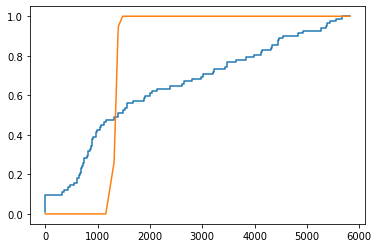

0.49990398129899105


In [215]:
cases_az = data[:, 2]
cases_az = np.sort(cases_az)
cdf_y = np.array([])
cdf = 0
n = len(cases_az)
max_diff = 0
poisson_cdf = np.array([])
for i in cases_az:
    poisson_point = poisson.cdf(i, cases_mme_poisson)
    poisson_cdf = np.append(poisson_cdf, poisson_point)
    if max_diff < np.abs(cdf-poisson_point):
        max_diff = np.abs(cdf-poisson_point)
    cdf += 1/n
    cdf_y = np.append(cdf_y, cdf)

plt.step(cases_az, cdf_y)
plt.plot(cases_az, poisson_cdf)
plt.show()
print(max_diff)

Null hypothesis : Cases AR(Poission distr) and Cases AZ distribution is same.

Alternate Hypothesis: Cases AR(Poission distr) and Cases AZ distributions are different.

Because p value = 0.49 > 0.05, we reject null hypothesis.

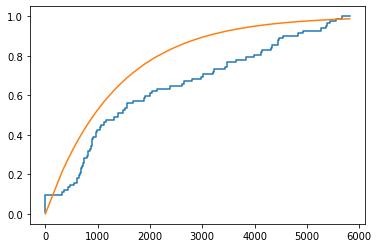

0.22464873365371807


In [216]:
cdf_y = np.array([])
cdf = 0
max_diff = 0
geom_cdf = np.array([])
for i in cases_az:
    geom_point = geom.cdf(i, cases_mme_geometric)
    geom_cdf = np.append(geom_cdf, geom_point)
    if max_diff < np.abs(cdf - geom_point):
        max_diff = np.abs(cdf - geom_point)
    cdf += 1 / n
    cdf_y = np.append(cdf_y, cdf)

plt.step(cases_az, cdf_y)
plt.plot(cases_az, geom_cdf)
plt.show()
print(max_diff)

Null hypothesis : Cases AR(Geometric distr) and Cases AZ distribution is same.

Alternate Hypothesis: Cases AR(Geomoetric distr) and Cases AZ distributions are different.

Because p value = 0.224 > 0.05, we reject null hypothesis.

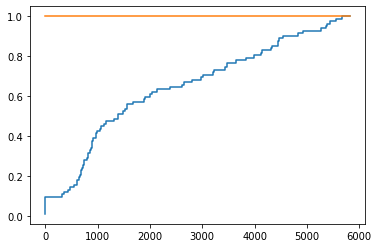

1.0


In [217]:
cdf_y = np.array([])
cdf = 0
max_diff = 0
binom_cdf = np.array([])
for i in cases_az:
    binom_point = binom.cdf(i, cases_mme_n_binomial, cases_mme_p_binomial)
    binom_cdf = np.append(binom_cdf, binom_point)
    if max_diff < np.abs(cdf - binom_point):
        max_diff = np.abs(cdf - binom_point)
    cdf += 1 / n
    cdf_y = np.append(cdf_y, cdf)

plt.step(cases_az, cdf_y)
plt.plot(cases_az, binom_cdf)
plt.show()
print(max_diff)

Null hypothesis : Cases AR(Binomial distr) and Cases AZ distribution is same.

Alternate Hypothesis: Cases AR(Binomial distr) and Cases AZ distributions are different.

Because p value = 1.0 > 0.05, we reject null hypothesis.





### KS One Population test for deaths

In [218]:
df = pd.read_csv('processed_deaths_ar.csv')
data = df.to_numpy()
data = data[252:336, :]

In [219]:
data

array([[253, '2020-10-01', 15.0],
       [254, '2020-10-02', 7.0],
       [255, '2020-10-03', 16.0],
       [256, '2020-10-04', 18.0],
       [257, '2020-10-05', 22.0],
       [258, '2020-10-06', 22.0],
       [259, '2020-10-07', 13.0],
       [260, '2020-10-08', 21.0],
       [261, '2020-10-09', 27.0],
       [262, '2020-10-10', 22.0],
       [263, '2020-10-11', 17.0],
       [264, '2020-10-12', 17.0],
       [265, '2020-10-13', 25.0],
       [266, '2020-10-14', 23.0],
       [267, '2020-10-15', 11.0],
       [268, '2020-10-16', 20.0],
       [269, '2020-10-17', 19.0],
       [270, '2020-10-18', 20.0],
       [271, '2020-10-19', 10.0],
       [272, '2020-10-20', 14.0],
       [273, '2020-10-21', 23.0],
       [274, '2020-10-22', 21.0],
       [275, '2020-10-23', 10.0],
       [276, '2020-10-24', 15.0],
       [277, '2020-10-25', 15.0],
       [278, '2020-10-26', 17.0],
       [279, '2020-10-27', 25.0],
       [280, '2020-10-28', 17.0],
       [281, '2020-10-29', 18.0],
       [282, '2

In [220]:
deaths_ar = data[:, 2]
deaths_sample_mean = np.mean(deaths_ar)
deaths_sample_variance = np.var(deaths_ar)
deaths_mme_poisson = deaths_sample_mean
deaths_mme_geometric = 1 / deaths_sample_mean
deaths_mme_p_binomial = 1 - deaths_sample_variance / deaths_sample_mean
deaths_mme_n_binomial = deaths_sample_mean ** 2 / (deaths_sample_mean - deaths_sample_variance)

In [221]:
print(deaths_mme_poisson)
print(deaths_mme_geometric)
print(deaths_mme_n_binomial)
print(deaths_mme_p_binomial)

22.202380952380953
0.04504021447721179
-5.734658143825416
-3.8716136856887546


In [222]:
df = pd.read_csv('processed_deaths_az.csv')
data = df.to_numpy()
data = data[247:332, :]

In [223]:
data

array([[253, '2020-10-01', 23.0],
       [254, '2020-10-02', 20.0],
       [255, '2020-10-03', 12.0],
       [256, '2020-10-04', 1.0],
       [257, '2020-10-05', 1.0],
       [258, '2020-10-06', 6.0],
       [259, '2020-10-07', 20.0],
       [260, '2020-10-08', 10.0],
       [261, '2020-10-09', 3.0],
       [262, '2020-10-10', 13.0],
       [263, '2020-10-11', 0.0],
       [264, '2020-10-12', 0.0],
       [265, '2020-10-13', 8.0],
       [266, '2020-10-14', 5.0],
       [267, '2020-10-15', 17.0],
       [268, '2020-10-16', 17.0],
       [269, '2020-10-17', 18.0],
       [270, '2020-10-18', 3.0],
       [271, '2020-10-19', 3.0],
       [272, '2020-10-20', 7.0],
       [273, '2020-10-21', 17.0],
       [274, '2020-10-22', 5.0],
       [275, '2020-10-23', 6.0],
       [276, '2020-10-24', 4.0],
       [277, '2020-10-25', 5.0],
       [278, '2020-10-26', 1.0],
       [279, '2020-10-27', 16.0],
       [280, '2020-10-28', 14.0],
       [281, '2020-10-29', 13.0],
       [282, '2020-10-30', 16.

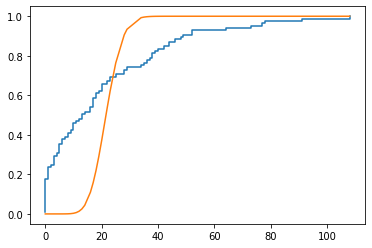

0.45702829377886567


In [224]:
deaths_az = data[:, 2]
deaths_az = np.sort(deaths_az)
cdf_y = np.array([])
cdf = 0
n = len(deaths_az)
max_diff = 0
poisson_cdf = np.array([])
for i in deaths_az:
    poisson_point = poisson.cdf(i, deaths_mme_poisson)
    poisson_cdf = np.append(poisson_cdf, poisson_point)
    if max_diff < np.abs(cdf - poisson_point):
        max_diff = np.abs(cdf - poisson_point)
    cdf += 1 / n
    cdf_y = np.append(cdf_y, cdf)

plt.step(deaths_az, cdf_y)
plt.plot(deaths_az, poisson_cdf)
plt.show()
print(max_diff)

Null hypothesis : Deaths AR(Poission distr) and Deaths AZ distribution is same.

Alternate Hypothesis: Deaths AR(Poission distr) and Deaths AZ distributions are different.

Because p value = 0.45 > 0.05, we reject null hypothesis.

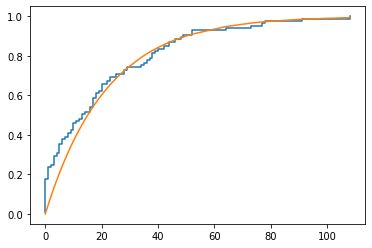

0.16672449140514123


In [225]:
cdf_y = np.array([])
cdf = 0
max_diff = 0
geom_cdf = np.array([])
for i in deaths_az:
    geom_point = geom.cdf(i,  deaths_mme_geometric)
    geom_cdf = np.append(geom_cdf, geom_point)
    if max_diff < np.abs(cdf - geom_point):
        max_diff = np.abs(cdf - geom_point)
    cdf += 1 / n
    cdf_y = np.append(cdf_y, cdf)

plt.step(deaths_az, cdf_y)
plt.plot(deaths_az, geom_cdf)
plt.show()
print(max_diff)

Null hypothesis : Deaths AR(Geometric distr) and Deaths AZ distribution is same.

Alternate Hypothesis: Deaths AR(Geometric distr) and Deaths AZ distributions are different.

Because p value = 0.16 > 0.05, we reject null hypothesis.

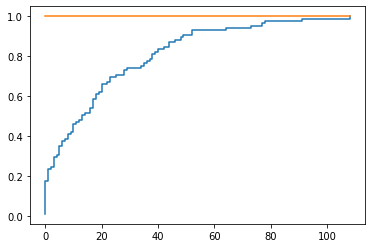

1.0


In [226]:
cdf_y = np.array([])
cdf = 0
max_diff = 0
binom_cdf = np.array([])
for i in deaths_az:
    binom_point = binom.cdf(i, deaths_mme_n_binomial, deaths_mme_p_binomial)
    binom_cdf = np.append(binom_cdf, binom_point)
    if max_diff < np.abs(cdf - binom_point):
        max_diff = np.abs(cdf - binom_point)
    cdf += 1 / n
    cdf_y = np.append(cdf_y, cdf)

plt.step(deaths_az, cdf_y)
plt.plot(deaths_az, binom_cdf)
plt.show()
print(max_diff)

Null hypothesis : Deaths AR(Binomial distr) and Deaths AZ distribution is same.

Alternate Hypothesis: Deaths AR(Binomial distr) and Deaths AZ distributions are different.

Because p value = 1.0 > 0.05, we reject null hypothesis.

### KS Two Population Test

In [227]:
def plot_eCDF(input_list, label, color):
    input_list.sort()
    # sort input array
    n = len(input_list)

    # initialize x and y to plt CDF
    x = [input_list[0]]
    y = [0]
    for point in input_list:
        value = y[len(y) - 1] + 1 / n
        # update x and y values
        x = x + [point, point]
        y = y + [y[len(y) - 1], value]

    # eCDF step function plot
    plt.plot(x, y, label=label, color=color)
    return x[1:], y[1:]

Max Difference:  0.378048780487803
Point with max Difference:  2382.0


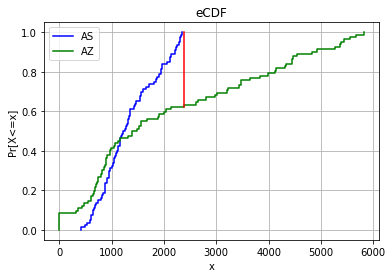

Reject Null Hypothesis


In [228]:
X = cases_ar
Y = cases_az

# plot the graphs
plt.figure('eCDF')
x1, y1 = plot_eCDF(X, 'AS', color='blue')
x2, y2 = plot_eCDF(Y, 'AZ', color='green')

max_difference = 0
point = 0
point_y1 = 0
point_y2 = 0
i = 0
j = 0
while i < len(x2):
    y2_left, y2_right = y2[i], y2[i + 1]
    while j + 2 < len(x1) and x1[j + 2] < x2[i]:
        j += 2
    if x2[i] == x1[j]:
        y1_left, y1_right = y1[j], y1[j + 1]
    else:
        y1_left, y1_right = y1[j + 1], y1[j + 1]
    if max_difference < np.max([max_difference, np.absolute(y1_left - y2_left), np.absolute(y1_right - y2_right)]):
        max_difference = np.max([max_difference, np.absolute(y1_left - y2_left), np.absolute(y1_right - y2_right)])
        point_y1 = y1_left
        point_y2 = y2_left
        point = x2[i]
    i += 2
print('Max Difference: ', max_difference)
print('Point with max Difference: ', point)

# graph properties
plt.plot([point, point], [point_y1, point_y2], color='red')
plt.xlabel('x')
plt.ylabel('Pr[X<=x]')
plt.title('eCDF')
plt.legend(loc="upper left")
plt.grid()
plt.show()

if max_difference > 0.05:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')

Null hypothesis : Cases AR and Cases AZ distribution is same.

Alternate Hypothesis: Cases AR and Cases AZ distributions are different.

Because p value = 0.37 > 0.05, we reject null hypothesis.

Max Difference:  0.37563025210084067
Point with max Difference:  10.0


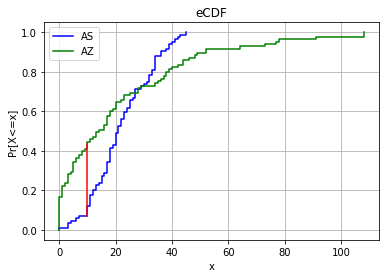

Reject Null Hypothesis


In [229]:
X = deaths_ar
Y = deaths_az

# plot the graphs
plt.figure('eCDF')
x1, y1 = plot_eCDF(X, 'AS', color='blue')
x2, y2 = plot_eCDF(Y, 'AZ', color='green')

max_difference = 0
point = 0
point_y1 = 0
point_y2 = 0
i = 0
j = 0
while i < len(x2):
    y2_left, y2_right = y2[i], y2[i + 1]
    while j + 2 < len(x1) and x1[j + 2] < x2[i]:
        j += 2
    if x2[i] == x1[j]:
        y1_left, y1_right = y1[j], y1[j + 1]
    else:
        y1_left, y1_right = y1[j + 1], y1[j + 1]
    if max_difference < np.max([max_difference, np.absolute(y1_left - y2_left), np.absolute(y1_right - y2_right)]):
        max_difference = np.max([max_difference, np.absolute(y1_left - y2_left), np.absolute(y1_right - y2_right)])
        point_y1 = y1_left
        point_y2 = y2_left
        point = x2[i]
    i += 2
print('Max Difference: ', max_difference)
print('Point with max Difference: ', point)

# graph properties
plt.plot([point, point], [point_y1, point_y2], color='red')
plt.xlabel('x')
plt.ylabel('Pr[X<=x]')
plt.title('eCDF')
plt.legend(loc="upper left")
plt.grid()
plt.show()

if max_difference > 0.05:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')

Null hypothesis : Deaths AR and Deaths AZ distribution is same.

Alternate Hypothesis: Deaths AR and Deaths AZ distributions are different.

Because p value = 0.37 > 0.05, we reject null hypothesis.

### Permutation Test

In [230]:
x1 = cases_ar
y1 = cases_az

X_avg = np.mean(x1)
Y_avg = np.mean(y1)
t_obs = np.absolute(X_avg - Y_avg)

number = 0
combined = np.append(x1, y1, axis=0)
for i in range(1000):
    permutation = np.random.permutation(combined)
    X_permutation = permutation[: len(x1)]
    Y_permutation = permutation[len(x1):]
    t_predict = np.absolute(np.mean(X_permutation) - np.mean(Y_permutation))
    if t_predict > t_obs:
        number += 1

p_value = number / 1000
print(p_value)
if p_value > 0.05:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')

0.0
Accept Null Hypothesis


Null hypothesis : Cases AR and Cases AZ distribution is different.

Alternate Hypothesis: Cases AR and Cases AZ distributions are same.

Because p value = 0.00 < 0.05, we accept null hypothesis.

In [231]:
x2 = deaths_ar
y2 = deaths_az

X_avg = np.mean(x2)
Y_avg = np.mean(y2)
t_obs = np.absolute(X_avg - Y_avg)

number = 0
combined = np.append(x2, y2, axis=0)
for i in range(1000):
    permutation = np.random.permutation(combined)
    X_permutation = permutation[: len(x2)]
    Y_permutation = permutation[len(x2):]
    t_predict = np.absolute(np.mean(X_permutation) - np.mean(Y_permutation))
    if t_predict > t_obs:
        number += 1

p_value = number / 1000
print(p_value)
if p_value > 0.05:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')

0.881
Reject Null Hypothesis


Null hypothesis : Cases AR and Cases AZ distribution is different.

Alternate Hypothesis: Cases AR and Cases AZ distributions are same.

Because p value = 0.88 > 0.05, we reject null hypothesis.

## Inference 4

In [232]:
from scipy.stats import gamma

This function plots the posterior distributions

In [233]:
def plot_posterior(alpha, beta, label):
    x = np.linspace(gamma.ppf(0.01, alpha, scale=1/beta),
                      gamma.ppf(0.99, alpha, scale=1/beta), 1000)
    pdf = gamma.pdf(x, alpha, scale=1/beta)
    print(label,"MAP :", x[np.argmax(pdf)])
    plt.plot(x, pdf, label=label + "MAP : " + str(x[np.argmax(pdf)]))
    plt.xlabel("Count")
    plt.ylabel("pdf of Gamma distribution")
    plt.legend()

Read the files that have the processed data.

In [234]:
cases_ar = pd.read_csv("/content/processed_cases_ar.csv")
cases_az = pd.read_csv("/content/processed_cases_az.csv")

Get the stats in both states for the given range.

In [235]:
cases_ar_range = cases_ar[(cases_ar.Date >= '2020-06-01') & (cases_ar.Date < '2020-07-28')]
cases_az_range = cases_az[(cases_az.Date >= '2020-06-01') & (cases_az.Date < '2020-07-28')]

Create a dataframe that has sum of cases in both states

In [236]:
sum_cases = pd.DataFrame(cases_ar_range["cases_ar"] + cases_az_range["cases_az"])
sum_cases.columns = ["combined_sum_cases"]

In [237]:
print(sum_cases)

     combined_sum_cases
131               194.0
132              1499.0
133              1218.0
134               893.0
135              1807.0
136              1570.0
137              1761.0
138              1100.0
139               959.0
140              1846.0
141              1859.0
142              2387.0
143              2088.0
144              1638.0
145              1432.0
146              2665.0
147              2243.0
148              2840.0
149              3944.0
150              3621.0
151              3016.0
152              2717.0
153              4362.0
154              2315.0
155              3743.0
156              4110.0
157              4163.0
158              4365.0
159              1064.0
160              5202.0
161              5297.0
162              4211.0
163              4980.0
164              3280.0
165              4143.0
166              3791.0
167              3912.0
168              4254.0
169              4863.0
170              4972.0
171             

Intervals refers to the weeks where we observe the data for Bayesian Inference after prior. 35 corresponds to 5th week, 42 corresponds to the 6th week, 49 corresponds to 7th week and 56 corresponds to 8th week.

lambda_mme is 1/sample mean

In [238]:
intervals = [35,42,49,56]

lambda_mme = (len(sum_cases[0:28]))/sum_cases[0:28]['combined_sum_cases'].sum()

Since the prior is an exponential distribution which is a Gamma(1,beta) distribution and the data is Poisson Distributed, the posteriors will also be Gamma distributions with alpha = 1 + sum of data points and beta = 7*iteration number + lambda_mme.

------- 1 -------
alpha is 28178.0
beta is 7.000421972722478
1th iteration MAP : 4025.0051282164513
------- 2 -------
alpha is 57109.0
beta is 14.000421972722478
2th iteration MAP : 4078.9976378111046
------- 3 -------
alpha is 83127.0
beta is 21.000421972722478
3th iteration MAP : 3958.3231491277907
------- 4 -------
alpha is 106912.0
beta is 28.000421972722478
4th iteration MAP : 3818.199114470787


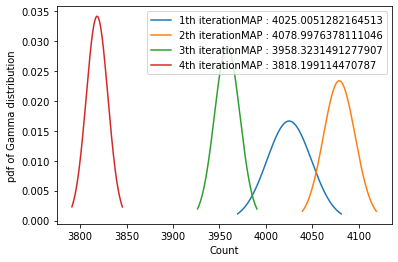

In [239]:
i=1
for interval in intervals:
    print("-------",i,"-------")
    alpha = 1 + sum_cases[28:interval]['combined_sum_cases'].sum()
    beta = 7*i + lambda_mme
    print("alpha is",alpha)
    print("beta is",beta)
    plot_posterior(alpha, beta, str(i)+"th iteration")
    i = i+1
plt.show()

In [240]:
deaths_ar = pd.read_csv("/content/processed_deaths_ar.csv")
deaths_az = pd.read_csv("/content/processed_deaths_az.csv")

In [241]:
deaths_ar_range = deaths_ar[(deaths_ar.Date >= '2020-06-01') & (deaths_ar.Date < '2020-07-28')]
deaths_az_range = deaths_az[(deaths_az.Date >= '2020-06-01') & (deaths_az.Date < '2020-07-28')]

In [242]:
sum_deaths = pd.DataFrame(deaths_ar_range["deaths_ar"] + deaths_az_range["deaths_az"])
sum_deaths.columns = ["combined_sum_deaths"]
sum_deaths.dropna(inplace=True)

In [243]:
lambda_mme = (len(sum_deaths[0:28]))/sum_deaths[0:28]['combined_sum_deaths'].sum()

------- 1 -------
alpha is 245.0
beta is 7.034610630407911
1th iteration MAP : 34.689680626291214
------- 2 -------
alpha is 598.0
beta is 14.034610630407911
2th iteration MAP : 42.53925829818935
------- 3 -------
alpha is 1082.0
beta is 21.03461063040791
3th iteration MAP : 51.38877362384676
------- 4 -------
alpha is 1298.0
beta is 28.03461063040791
4th iteration MAP : 46.265582687589735


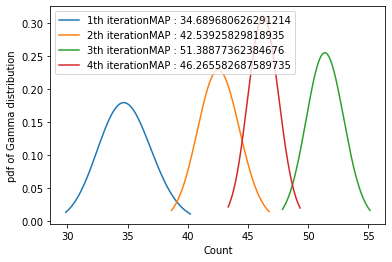

In [244]:
i=1
for interval in intervals:
    print("-------",i,"-------")
    alpha = 1 + sum_deaths[28:interval]['combined_sum_deaths'].sum()
    beta = 7*i + lambda_mme
    print("alpha is",alpha)
    print("beta is",beta)
    plot_posterior(alpha, beta, str(i)+"th iteration")
    i = i+1
plt.show()

# Question 3

In [245]:
!cp -r /content/drive/MyDrive/ProbStat_HW/US_confirmed.csv /content
!cp -r /content/drive/MyDrive/ProbStat_HW/US_deaths.csv /content
!cp -r /content/drive/MyDrive/ProbStat_HW/aqi_data.csv /content

cp: cannot stat '/content/drive/MyDrive/ProbStat_HW/US_confirmed.csv': No such file or directory
cp: cannot stat '/content/drive/MyDrive/ProbStat_HW/US_deaths.csv': No such file or directory
cp: cannot stat '/content/drive/MyDrive/ProbStat_HW/aqi_data.csv': No such file or directory


## Data Preprocessing



In [246]:
data = []

with open('US_confirmed.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)

headers = data[0]
data = data[1:]

for row in data:
    if row[0] == 'MA':
        data = row
        break

headers = headers[1:]
data = data[1:]

case_data = [0]
for i in range(1, len(data)):
    if (int(data[i])  - int(data[i-1])) < 0:
        case_data.append(0)
    else:
        case_data.append(int(data[i])  - int(data[i-1]))

data = {'date': headers, 'cases': case_data}
df = pd.DataFrame(data=data)
# print(df)

df.to_csv('processed_cases_ma.csv')


In [247]:
data = []

with open('US_deaths.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)

headers = data[0]
data = data[1:]

for row in data:
    if row[0] == 'MA':
        data = row
        break

headers = headers[1:]
data = data[1:]

case_data = [0]
for i in range(1, len(data)):
    if (int(data[i])  - int(data[i-1])) < 0:
        case_data.append(0)
    else:
        case_data.append(int(data[i])  - int(data[i-1]))

data = {'date': headers, 'deaths': case_data}
df = pd.DataFrame(data=data)
# print(df)

df.to_csv('processed_deaths_ma.csv')

## Inference 1 : Chi square test

Chi Square Test: Checking independence between Air Quality Index(AQI) and Covid Cases/deaths in Greater Boston Area.
The null hypothesis is: AQI and covid cases/deaths are independent in Greater Boston Area. 


In [248]:
cases_ma = []
aqi = []
deaths_ma = []

with open('processed_cases_ma.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        cases_ma.append(row)

with open('processed_deaths_ma.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        deaths_ma.append(row)

with open('aqidaily2020.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        aqi.append(row)

aqi = aqi[22:]
cases_ma = cases_ma[1:346]
deaths_ma = deaths_ma[1:346]
data = []
for row in aqi:
    data.append(int(row[1]))
aqi = np.array(data)

data = []
for row in cases_ma:
    data.append(int(row[2]))
cases_ma = np.array(data)

data = []
for row in deaths_ma:
    data.append(int(row[2]))
deaths_ma = np.array(data)



In [249]:
np.sort(aqi)
combined = np.append(np.atleast_2d(cases_ma).T, np.atleast_2d(aqi).T, axis=1)
mean_cases_40 = np.mean(combined[combined[:,1]<40][:, 0])
test = combined[combined[:,1]>40]
test = test[test[:,1]<60]
mean_cases_60 = np.mean(test[:,0])

test = combined[combined[:,1]>60]
test = test[test[:,1]<80]
mean_cases_80 = np.mean(test[:,0])

test = combined[combined[:,1]>60]
test = test[test[:,1]<80]
mean_cases_80 = np.mean(test[:,0])

test = combined[combined[:,1]>80]
test = test[test[:,1]<100]
mean_cases_100 = np.mean(test[:,0])

list_cases = [mean_cases_40, mean_cases_60, mean_cases_80, mean_cases_100]

list_cases

[1145.6328125, 897.9171597633136, 1317.5454545454545, 321.0]

In [250]:
combined = np.append(np.atleast_2d(deaths_ma).T, np.atleast_2d(aqi).T, axis=1)
mean_deaths_40 = np.mean(combined[combined[:,1]<40][:, 0])
test = combined[combined[:,1]>40]
test = test[test[:,1]<60]
mean_deaths_60 = np.mean(test[:,0])

test = combined[combined[:,1]>60]
test = test[test[:,1]<80]
mean_deaths_80 = np.mean(test[:,0])

test = combined[combined[:,1]>60]
test = test[test[:,1]<80]
mean_deaths_80 = np.mean(test[:,0])

test = combined[combined[:,1]>80]
test = test[test[:,1]<100]
mean_deaths_100 = np.mean(test[:,0])

list_deaths = [mean_deaths_40, mean_deaths_60, mean_deaths_80, mean_deaths_100]

list_deaths

[30.78125, 44.094674556213015, 25.09090909090909, 9.333333333333334]

In [251]:
total_cases = np.sum(list_cases)
total_deaths = np.sum(list_deaths)
total = total_cases + total_deaths
total_aqi_range = []

for i in range(0, len(list_cases)):
    total_aqi_range.append(list_cases[i] + list_deaths[i])

q_obs = 0

for i in range(0, len(list_cases)):
    expected = (total_aqi_range[i] * total_cases)/total
    q_obs += ( ((expected - list_cases[i])*(expected - list_cases[i]))/expected )

for i in range(0, len(list_deaths)):
    expected = (total_aqi_range[i] * total_deaths)/total
    q_obs += ( ((expected - list_deaths[i])*(expected - list_deaths[i]))/expected )

df = 3
print('Q observer is: ', q_obs, ' Degrees of freedom:',df)
print('p-value from table lookup 0.001076  < 0.05')
print('We are rejecting null hypothesis, so AQI(air quality index) and covid cases/deaths are not independent in Greater Boston Area.')

Q observer is:  16.111272972266054  Degrees of freedom: 3
p-value from table lookup 0.001076  < 0.05
We are rejecting null hypothesis, so AQI(air quality index) and covid cases/deaths are not independent in Greater Boston Area.


We are rejecting null hypothesis, so AQI(air quality index) and covid cases/deaths are not independent in Greater Boston Area.


## Inference 2: Pearson correlation test

Pearson Correlation Test:
To check correlation between Air Quality Index and Covid Cases/Deaths at Greater Boston Area.

In [252]:
cases_ma = []
aqi = []
deaths_ma = []

with open('processed_cases_ma.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        cases_ma.append(row)

with open('processed_deaths_ma.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        deaths_ma.append(row)

with open('aqidaily2020.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        aqi.append(row)

aqi = aqi[22:]
cases_ma = cases_ma[1:346]
deaths_ma = deaths_ma[1:346]

data = []
for row in aqi:
    data.append(int(row[1]))
aqi = data

data = []
for row in cases_ma:
    data.append(int(row[2]))
cases_ma = data

data = []
for row in deaths_ma:
    data.append(int(row[2]))
deaths_ma = data

print(aqi)


m1 = np.mean(aqi)
m2 = np.mean(cases_ma)
v1 = np.var(aqi)
v2 = np.var(cases_ma)
sum = 0
n = len(aqi)
for i in range(0, n):
    sum += ((aqi[i] - m1)*(cases_ma[i] - m2))
numerator = sum/n
denominator = np.sqrt(v1*v2)
pc = numerator/denominator
print("Pearson correlation for Cases and AQI",pc)

m1 = np.mean(aqi)
m2 = np.mean(deaths_ma)
v1 = np.var(aqi)
v2 = np.var(deaths_ma)
sum = 0
n = len(aqi)
for i in range(0, n):
    sum += ((aqi[i] - m1)*(deaths_ma[i] - m2))
numerator = sum/n
denominator = np.sqrt(v1*v2)
pc = numerator/denominator
print("Pearson correlation for Deaths and AQI", pc)


[58, 67, 63, 39, 31, 23, 38, 40, 38, 46, 51, 57, 46, 54, 41, 33, 35, 36, 36, 45, 54, 38, 45, 36, 36, 42, 45, 38, 40, 40, 39, 46, 56, 57, 58, 53, 46, 40, 37, 40, 52, 54, 40, 42, 48, 42, 44, 49, 55, 39, 37, 39, 40, 44, 41, 39, 43, 41, 45, 41, 41, 40, 40, 41, 44, 43, 49, 44, 44, 44, 40, 37, 39, 38, 39, 42, 45, 43, 51, 36, 40, 48, 46, 45, 51, 41, 44, 44, 54, 41, 53, 44, 47, 46, 51, 44, 41, 40, 38, 51, 47, 41, 55, 44, 33, 38, 44, 44, 40, 44, 45, 39, 42, 49, 58, 40, 42, 41, 38, 42, 51, 51, 42, 41, 46, 42, 44, 26, 28, 40, 31, 32, 42, 58, 64, 53, 46, 34, 32, 43, 53, 44, 44, 37, 44, 39, 37, 74, 45, 45, 61, 51, 42, 67, 51, 47, 67, 50, 47, 39, 35, 43, 48, 40, 79, 68, 32, 38, 51, 61, 33, 40, 38, 44, 41, 22, 36, 30, 45, 90, 51, 46, 44, 44, 43, 53, 45, 80, 48, 48, 71, 45, 50, 42, 49, 51, 54, 44, 44, 46, 51, 90, 97, 67, 46, 53, 49, 40, 36, 39, 42, 38, 74, 50, 47, 61, 46, 34, 37, 39, 39, 28, 37, 31, 27, 36, 40, 35, 49, 38, 46, 46, 31, 25, 32, 37, 28, 32, 34, 44, 30, 30, 30, 33, 35, 46, 57, 61, 67, 33,

Conclusion for the above test: Negative values indicate negative correlation between AQI and Cases/Deaths. So as Covid Cases/Deaths increase, the AQI decreases.

## Inference 3: KS Two population test

Max Difference:  0.7739130434782517
Point with max Difference:  97


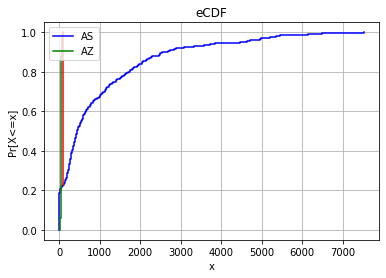

Reject Null Hypothesis


In [253]:
X = cases_ma
Y = aqi
# plot the graphs
plt.figure('eCDF')
x1, y1 = plot_eCDF(X, 'AS', color='blue')
x2, y2 = plot_eCDF(Y, 'AZ', color='green')

max_difference = 0
point = 0
point_y1 = 0
point_y2 = 0
i = 0
j = 0
while i < len(x2):
    y2_left, y2_right = y2[i], y2[i + 1]
    while j + 2 < len(x1) and x1[j + 2] < x2[i]:
        j += 2
    if x2[i] == x1[j]:
        y1_left, y1_right = y1[j], y1[j + 1]
    else:
        y1_left, y1_right = y1[j + 1], y1[j + 1]
    if max_difference < np.max([max_difference, np.absolute(y1_left - y2_left), np.absolute(y1_right - y2_right)]):
        max_difference = np.max([max_difference, np.absolute(y1_left - y2_left), np.absolute(y1_right - y2_right)])
        point_y1 = y1_left
        point_y2 = y2_left
        point = x2[i]
    i += 2
print('Max Difference: ', max_difference)
print('Point with max Difference: ', point)

# graph properties
plt.plot([point, point], [point_y1, point_y2], color='red')
plt.xlabel('x')
plt.ylabel('Pr[X<=x]')
plt.title('eCDF')
plt.legend(loc="upper left")
plt.grid()
plt.show()

if max_difference > 0.05:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')

Null hyp is both distributions are same.

alternate hyp: both distributions are different.

p value is 0.77 > 0.05. So we reject null hypothesis

Max Difference:  0.5999999999999975
Point with max Difference:  29


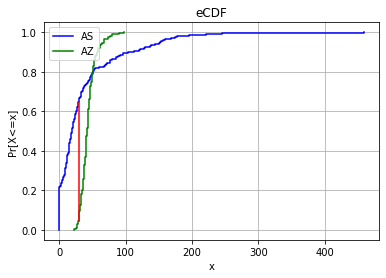

Reject Null Hypothesis


In [254]:
X = deaths_ma
Y = aqi
# plot the graphs
plt.figure('eCDF')
x1, y1 = plot_eCDF(X, 'AS', color='blue')
x2, y2 = plot_eCDF(Y, 'AZ', color='green')

max_difference = 0
point = 0
point_y1 = 0
point_y2 = 0
i = 0
j = 0
while i < len(x2):
    y2_left, y2_right = y2[i], y2[i + 1]
    while j + 2 < len(x1) and x1[j + 2] < x2[i]:
        j += 2
    if x2[i] == x1[j]:
        y1_left, y1_right = y1[j], y1[j + 1]
    else:
        y1_left, y1_right = y1[j + 1], y1[j + 1]
    if max_difference < np.max([max_difference, np.absolute(y1_left - y2_left), np.absolute(y1_right - y2_right)]):
        max_difference = np.max([max_difference, np.absolute(y1_left - y2_left), np.absolute(y1_right - y2_right)])
        point_y1 = y1_left
        point_y2 = y2_left
        point = x2[i]
    i += 2
print('Max Difference: ', max_difference)
print('Point with max Difference: ', point)

# graph properties
plt.plot([point, point], [point_y1, point_y2], color='red')
plt.xlabel('x')
plt.ylabel('Pr[X<=x]')
plt.title('eCDF')
plt.legend(loc="upper left")
plt.grid()
plt.show()

if max_difference > 0.05:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')

Null hyp is both distributions are same.

alternate hyp: both distributions are different.

p value is 0.599 > 0.05. So we reject null hypothesis